# Introduction to `lamatrix`

`lamatrix` is a tool to help you fit linear models to data. This tool is designed to make it easier to build models and fit them. 

These are the basic principles behind `lamatrix`. 

Firstly, let's create some data.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
x = np.arange(-1, 1, 0.01)
y = x * 2.3459 + 1.435 + np.random.normal(0, 0.3, size=len(x))
ye = np.ones(len(x)) * 0.3

<ErrorbarContainer object of 3 artists>

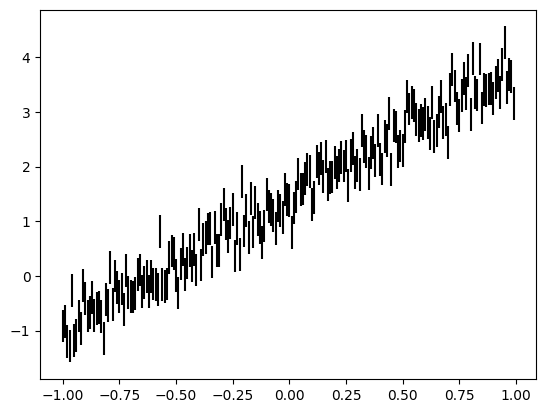

In [3]:
plt.errorbar(x, y, ye, ls='', c='k')

I have generated some synthetic data with the relation 

$y = mx + c$

where I have fixed $m$ and $c$. This is a very simple model, where I know the answer for the two variables I would like to fit. We can fit this with `lamatrix`.

Our first question is what model is reasonable to fit this data. `lamatrix` has the following model options

* constant
* polynomial
* step
* sinusoid
* Gaussian
* spline

From this list, we know that our data is drawn from a polynomial. 

## `Model` Class

`lamatrix` provides a `Model` class to work with. `Model`s are classes that are (usually) initialized with the name(s) of any variables that the model is a function of. These names are strings. `Model`s may have additional keyword arguments that are required on initialization. `Model`s have the following class methods that you will usually interact with

* `design_matrix`: The `design_matrix` method will return the design matrix that describes the model for all the input variables.
* `fit`: The `fit` method takes in data and optionally errors to fit the functional form of the model to data
* `evaluate` The `evaluate` method will return the best fit of the model to the data

Let's look at an example

In [4]:
from lamatrix import Polynomial

The `Polynomial` class is a type of `Model` in `lamatrix`. We will initialize it with the name of the variable of the polynomial, and the order of the polynomial. Let's make a model using this class

In [5]:
Polynomial('x', order=1)

Polynomial(x)[n, 1]

`p` is an `n` by `1` polynomial model. Here `n` indicates the number of points in the variable (`x`) and `1` indicates how many vectors are in the design matrix. If we increase the order, we will see this number increase

In [6]:
Polynomial('x', order=4)

Polynomial(x)[n, 4]

We can check the equation of our model object using the `equation` property

In [7]:
print(Polynomial('x', order=1).equation)

\[f(\mathbf{x}) = w_{0} \mathbf{x}^{1}\]


This latex equation shows the model. Let's display the latex here:
$$
f(\mathbf{x}) = w_{0} \mathbf{x}^{1}
$$

This is a simple model of some unknown weight $w_0$ multiplied by $x$. 

To make this model fit our data we will need to include a constant term.

In [8]:
from lamatrix import Constant

In [9]:
Constant()

Constant()[n, 1]

This `Model` does not require any input, there is no variable. If we print the equation we see it contains only an unknown weight

In [10]:
print(Constant().equation)

\[f() = w_{0} \]


Let's combine these `Model`s.

In [11]:
model = Polynomial('x', order=1) + Constant()

In [12]:
model

JointModel
	Polynomial(x)[n, 1]
	Constant()[n, 1]

Now we have combined the model we have a `JointModel`. Let's look at the equation now

In [13]:
print(model.equation)

\[f(\mathbf{x}) = w_{0} \mathbf{x}^{1} + w_{1} \]


In latex we have
$$
f(\mathbf{x}) = w_{0} \mathbf{x}^{1} + w_{1}
$$

This is now our first order polynomial, including the offset term. We have two unknown weights: $w_0$ and $w_1$ representing the slope and intercept of our model.

Our model contains a design matrix, which is the matrix representation of the equation above. When dotted with a vector of weights ($\mathbf{w}$) this gives us a realization of our model. We can access the design matrix inside the `Model` object. The `design_matrix` method will return the design matrix. You must input examples of all variables where you want the design matrix to be evaluated. In this case, that is `x`.

This can be any `x` that could be generated. Here I've generated an short example `x` vector.

In [14]:
x_example = np.arange(-1, 1, 0.25)
model.design_matrix(x=x_example)

array([[-1.  ,  1.  ],
       [-0.75,  1.  ],
       [-0.5 ,  1.  ],
       [-0.25,  1.  ],
       [ 0.  ,  1.  ],
       [ 0.25,  1.  ],
       [ 0.5 ,  1.  ],
       [ 0.75,  1.  ]])

This design matrix represents `x` and a constant. 

Now we have the model, let's fit it to the data. We will input the variables (`x`) and the data we want to fit.

In [15]:
model.fit(x=x, data=y)

We can plot the model over the data to see the fit

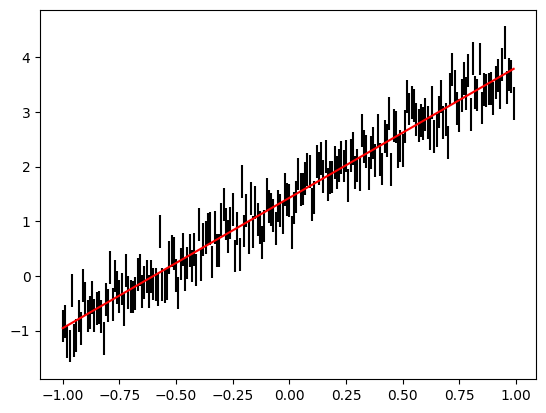

In [16]:
plt.errorbar(x, y, ye, ls='', c='k')
plt.plot(x, model.evaluate(x=x), c='r')

This is a good fit. To see the results of the fit we must first introduce a new class: `Distribution`s.

There are two occasions inside `lamatrix` where we require some concept of a distribution.

1. The **prior** distribution: this holds our prior belief of the values of best fitting weights. By default, all priors are infintely wide Gaussians (i.e. we have no prior understanding).
2. The **posterior** distribution: this holds the best fitting values after we have fit our model to data, informed by the prior.

Both of these are Gaussian distributions in `lamatrix`. We use the following Python objects to hold these distributions.

## `Distribution`

In `lamatrix` all distributions are by definition Gaussian. These are specified by two parameters: the **mean** and the **standard deviation**. These are specified as `Tuple` objects with `(mean, standard deviation)`, e.g.
```
(0, 1)
```

Would indicate a Gaussian with mean 0 and standard deviation 1.

Distributions have special properties compared with regular tuples:

* `mean` and `std` properties return the mean and standard deviation as floats respectively
* freezing/thawing: In `lamatrix` you may want to "freeze" a certain variable to its mean value, i.e. make the standard deviation 0. `Distribution` classes have the `freeze` and `thaw` methods to enable this.
* you can draw a sample from the distribution using the `sample` method

## `DistributionContainer`

One `Tuple` `Distribution` object is valid for each weight we fit in the model. We must hold many weights to account for all of the components in the model. These are held in a `DistributionContainer`. This is a special case of a `List` which has the following methods

* `mean` and `std` properties return the mean and standard deviation as `numpy.NDArray`'s respectively
* `freeze` and `thaw` methods as above
* `sample` method as above

Now that we understand distibutions, we can return to the model. To find the best fit of our model, we need to access the `posteriors`. These are the results of the fit. 

In [17]:
model.posteriors

DistributionContainer
	[(2.3828630058675317, 0.12247601809895359), (1.4276597702903404, 0.07071332978565806)]

These posteriors represent the mean and standard deviation of the best fit weights for our model. We can look at the means

In [18]:
model.posteriors.mean

array([2.38286301, 1.42765977])

These values match the input $m$ and $c$ very closely! These represent our best fitting weights. 

Let's improve our fit by including errors on the data.

In [19]:
model.fit(x=x, data=y, errors=ye)

Now we have fit again, let's look at the mean

In [20]:
model.posteriors.mean

array([2.38286301, 1.42765977])

The posterior standard deviation now includes a more reasonable estimate of the error on these best fit parameters

In [21]:
model.posteriors.std

array([0.03674281, 0.021214  ])

We can plot this new model fit over the data. Here we draw 100 samples of the model, which draws weights from the posterior distribution, rather than using the best fit mean.

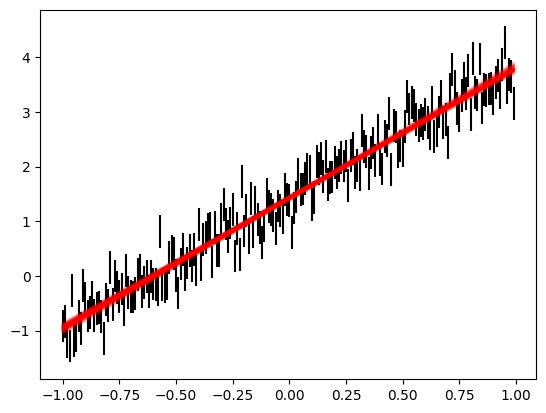

In [22]:
plt.errorbar(x, y, ye, ls='', c='k')
plt.plot(x, np.asarray([model.sample(x=x) for count in range(100)]).T, c='r', alpha=0.1);

Often we want to be able to save a model to share it with colleagues. `Model` objects are able to save and load models using `json` files.

In [24]:
model.save('output.json')

This saves a juman readable model. Below we show the first 20 lines of this file

In [29]:
!head -20 output.json

{
    "object_type": "JointModel",
    "initializing_kwargs": {},
    "priors": {
        "mean": [
            0,
            0
        ],
        "std": [
            Infinity,
            Infinity
        ]
    },
    "posteriors": {
        "mean": [
            2.382863005867531,
            1.4276597702903426
        ],
        "std": [
            0.03674280542968608,


The model json can then be loaded back in to lamatrix

In [30]:
from lamatrix import load

In [31]:
load('output.json')

JointModel
	Polynomial(x)[n, 1]
	Constant()[n, 1]

Finally you may want to include the results of your model as a latex table in your work. You can do this by using the `to_latex` method, which will also return the equation. 

In [37]:
print(model.to_latex())

\[f(\mathbf{x}) = w_{0} \mathbf{x}^{1} + w_{1} \]
\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|}
\hline
Coefficient & Posterior & Prior \\\hline
w & $2.38 \pm 0.04$  & $0 \pm \infty$ \\\hline
w & $1.43 \pm 0.02$  & $0 \pm \infty$ \\\hline
\end{tabular}
\end{table}
